### 数据清洗和绘图观察数据

In [51]:
import pandas as pd
import numpy as np
import warnings
import re
from sklearn.manifold import TSNE
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
from pyecharts import WordCloud
from collections import Counter
import multiprocessing
from gensim.models import Word2Vec
from aip import AipNlp
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

# 忽略警告
warnings.filterwarnings('ignore')

In [7]:
# 查看数据的基本格式
df = pd.read_csv('./JianShuJiaoYou-All-Data.csv',encoding='utf-8')
print(df.columns)
# df.head(5)

Index(['Page', 'Num', 'Author', 'Author_Url', 'Title', 'Time', 'Read',
       'Comment', 'Like', 'Abstract', 'Artical_Url', 'Image_Url',
       'Artical_Content'],
      dtype='object')


### 提取文章中200个关键词绘制词云

In [18]:
content = df['Artical_Content'].tolist()
# print(len(content),'\n',content[-1])

In [19]:
# 载入停用词
# quoting : int or csv.QUOTE_* instance, default 0
# 控制csv中的引号常量。可选 QUOTE_MINIMAL (0), QUOTE_ALL (1), QUOTE_NONNUMERIC (2) or QUOTE_NONE (3)
 
stopwords = pd.read_csv('./chinesestopword.txt',sep='\n',encoding='utf-8',names=['stopwords'],header=None,quoting=3)
# 默认输出5个
stopwords.head()

,stopwords
0,!
1,""""
2,#
3,$
4,%


In [20]:
# 结巴分词
pattern = re.compile('\d+')

# 存放词语和词频
wordsCounter = Counter()

for line in content:
    segs = jieba.lcut(line)
    for seg in segs:
        if len(seg)>1 and seg != '\r\n' and re.search(pattern,seg)==None:
            wordsCounter[seg] += 1

print(wordsCounter.most_common(100))

# 将Counter的键提取出来做list
segment = list(wordsCounter)

# 将分好的词列表转化为词典
words = pd.DataFrame({'segment':segment})

# 剔除停用词
words = words[~words['segment'].isin(stopwords['stopwords'])]

[('喜欢', 9535), ('一个', 9314), ('自己', 9078), ('我们', 7539), ('没有', 4949), ('可以', 4830), ('时候', 3910), ('知道', 3571), ('一起', 3481), ('因为', 3445), ('就是', 3358), ('什么', 3132), ('简书', 2948), ('生活', 2787), ('希望', 2735), ('还是', 2734), ('觉得', 2636), ('朋友', 2621), ('这个', 2549), ('不是', 2468), ('如果', 2450), ('现在', 2365), ('很多', 2363), ('所以', 2363), ('但是', 2321), ('这样', 2155), ('不会', 2069), ('文章', 1981), ('一直', 1926), ('开始', 1744), ('真的', 1697), ('那么', 1672), ('一样', 1622), ('时间', 1606), ('可能', 1567), ('他们', 1543), ('只是', 1539), ('看到', 1539), ('还有', 1507), ('其实', 1505), ('大家', 1490), ('故事', 1452), ('文字', 1448), ('工作', 1440), ('感觉', 1368), ('一些', 1360), ('别人', 1355), ('那个', 1344), ('一定', 1326), ('已经', 1290), ('事情', 1283), ('然后', 1267), ('我会', 1264), ('大学', 1231), ('世界', 1229), ('遇见', 1222), ('虽然', 1216), ('特别', 1189), ('爱情', 1166), ('不要', 1155), ('写作', 1151), ('东西', 1122), ('怎么', 1107), ('地方', 1103), ('一次', 1096), ('认识', 1082), ('这么', 1073), ('后来', 1062), ('这里', 1062), ('努力', 1060), ('可是', 1055), ('一下'

In [23]:
# 绘制词云
def counter2list(_counter):
    wordslist,nums = [],[]
    for item in _counter:
        wordslist.append(item[0])
        nums.append(item[1])
    return wordslist,nums

outputFile = './result/文章关键词词云图.html'

# 这个关键词抽取方法不唯一
wordslist,nums = counter2list(wordsCounter.most_common(1000))

cloud = WordCloud('文章关键词词云', width=1200, height=600, title_pos='center')
cloud.add(
    ' ',
    wordslist,nums,
    shape='circle',
    background_color='white',
    max_words=1000 
)

cloud.render(outputFile)

### word2vec模型计算词的相似度

In [26]:
# 基于TF-IDF算法的关键词抽取
contentStr = ''.join(content)
# keyWordsList = jieba.analyse.extract_tags(contentStr,topK=200,allowPOS=('ns','n'))
# textrank1 = ' '.join(keyWordsList)
# textrank1

'简书 时候 朋友 简友 文章 交友 我会 文字 故事 投稿 爱情 感觉 大家 大学 时间 专题 事情 人生 老师 树洞 世界 东西 同学 照片 地方 女生 电影 情书 性格 昵称 有点 交流 学校 梦想 内心 经历 时光 男生 作者 读书 城市 女孩 姑娘 孩子 单身 毕业 感情 凡人 青春 样子 名字 摄影 男朋友 校园 灵魂 父母 日子 对方 问题 学生 手机 朋友圈 小说 年龄 美食 专业 职业 评论 哥哥 心情 星座 女朋友 跑步 账号 素材 体重 陌生人 小伙伴 音乐 唱歌 好友 文艺 自我介绍 见面 画画 室友 个人 姐姐 陪伴 风景 妈妈 想象 地点 缘分 闺蜜 社群 回家 习惯 篇文章 现实 记录 无法 图书馆 性别 公众 理想 原因 关系 平台 北京 兴趣 游戏 结果 粉丝 小时候 美丽 情感 礼物 男人 总会 女孩子 方式 机会 宿舍 程序员 长大 舍友 陌生 印象 文学 私信 妹子 嘉宾 校友 话题 男孩 学会 模样 交朋友 联系 声音 眼睛 家乡 记忆 编辑 小时 女人 颜值 无戒 世间 能力 缺点 写文章 脾气 先生 家庭 家人 写字 身体 大神 咖啡 读者 码字 上海 线下 晚安 热情 社会 幻想 衣服 群里 生气 教室 吉他 学历 成绩 笔名 味道 情绪 意义 状态 异地 民谣 励志 学姐 爸妈 天空 作品 书写 友情 妹妹 思想 心灵 成都 老爸 学长 文笔 婚姻 小学 目标'

In [44]:
# 基于TextRank算法进行关键词抽取
textrank2 = ' '.join(jieba.analyse.textrank(contentStr,topK=500,allowPOS=('ns','n')))
textrank2

'时候 简书 朋友 文章 大家 交友 时间 大学 文字 故事 简友 感觉 老师 我会 爱情 学校 专题 世界 职业 人生 投稿 电影 地方 有点 作者 城市 东西 同学 学生 树洞 地点 经历 事情 照片 读书 孩子 问题 专业 毕业 性格 姑娘 北京 校园 交流 小说 昵称 女生 上海 摄影 手机 内心 女孩 中国 个人 梦想 星座 父母 名字 男生 音乐 青春 年龄 家乡 时光 感情 文学 对方 文化 样子 无法 公司 美丽 素材 文艺 社会 记录 哥哥 灵魂 妈妈 单身 美食 日子 家庭 回家 情书 平台 心情 关系 结果 性别 原因 能力 眼睛 方面 咖啡 编辑 唱歌 游戏 评论 小时 现实 画画 声音 小时候 历史 姐姐 情感 理想 方式 跑步 男人 想象 凡人 图书馆 内容 时代 见面 大赛 身体 衣服 宿舍 嘉宾 女人 总会 公众 风景 学会 陌生 兴趣 基本 学历 精神 成都 先生 好友 校友 习惯 作品 教室 艺术 思想 小学 男朋友 线下 联系 社群 武汉 家人 信息 模样 礼物 世间 长大 味道 陌生人 广州 父亲 朋友圈 印象 机会 女性 体重 空间 妹子 玫瑰 记忆 婚姻 人们 重庆 热情 杭州 计划 情况 读者 男孩 西安 小伙伴 励志 会员 少女 火车 体验 深圳 幻想 人物 陪伴 情绪 人家 意义 室友 大学生 国家 女孩子 山东 状态 程序员 天空 链接 思维 标准 所在地 写字 女朋友 散文 话题 吉他 女子 江湖 心灵 过程 账号 传统 江南 云南 全部 书籍 羽毛球 力量 南京 建筑 母亲 代表 爸爸 建议 材质 白色 自我介绍 公园 技术 电话 缺点 学院 产生 大神 笔名 情侣 目标 距离 图片 独家 民谣 校区 气息 主题 粉丝 心理 动漫 无戒 妹妹 姓名 樱花 方向 脾气 成绩 颜值 整理 日本 作家 苏州 湖南 舍友 天津 诗歌 农村 河南 电脑 教师 鸡汤 爱好者 产品 心理学 黑色 语文 操场 老家 大海 网络 环境 四川 中心 研究生 太阳 广东 中学 篮球 行业 女儿 经济 古风 缘分 理性 风格 典型 蓝色 视频 时期 绘画 女神 写文章 头发 友情 同事 体会 新疆 老板 湖北 男女 闺蜜 房子 书写 领导 用心 大理 大叔 地址 条件 对象 人间 浓情 互联网 信号 生气 部分 帅气 外表 美女 形式

In [29]:
# 利用word2vec找出关联词语，将语料整理成嵌套列表的形式
corpus = []

# 将停用词dataFrame转化为列表
stopwordsList = stopwords['stopwords'].tolist()
# print(stopwordsList[:10])
for line in content:
    segs = jieba.lcut(line)
    segs = filter(lambda x:len(x)>1, segs)
    segs = filter(lambda x:re.search(pattern,x)==None, segs)
    segs = filter(lambda x:x not in stopwordsList, segs)
    
    corpus.append(list(segs))

In [31]:
# 训练模型
model = Word2Vec(corpus,min_count=20,sg=0,workers=multiprocessing.cpu_count())
# 查询和简书相关性比较高的词语
model.wv.most_similar(['简书'],topn=15)

[('平台', 0.9402327537536621),
 ('创作', 0.9061471819877625),
 ('书上', 0.898600161075592),
 ('签约', 0.8965737819671631),
 ('这篇', 0.8820432424545288),
 ('训练营', 0.8790323734283447),
 ('小伙伴', 0.8787158727645874),
 ('简书里', 0.8774827718734741),
 ('推荐', 0.8771198987960815),
 ('机会', 0.8754802346229553),
 ('读者', 0.8753641843795776),
 ('发表', 0.8751234412193298),
 ('作者', 0.8716281652450562),
 ('书写', 0.8703430891036987),
 ('专题', 0.8679258823394775)]

### t-SNE 可视化高维数据
t-SNE是目前最为流行的一种高维数据降维的算法

In [37]:
# 调用百度云NLP进行词向量表示
APP_ID = '11617353'
API_KEY = 'eV2R48IOWKcLgBrZwtf0ZF7N'
SECRET_KEY = 'HHtuGb3BPGaXAguPld5r9gfrY4xCCdzh'
client = AipNlp(APP_ID, API_KEY, SECRET_KEY)

In [45]:
# 获取textrank2中Top200词语的词向量
textrankList = textrank2.split(' ')

In [46]:
# 整理格式 原始格式：('简书', 0.9286492277441794) 后者是特征权重
words_list = []
word_vectors = []

for word in textrankList:
    try:
        data = client.wordEmbedding(word)
#         print(data)
        word_vector = data['vec']
        words_list.append(data['word'])
        word_vectors.append(word_vector)
    except:
        print('No words:{}'.format(word))
    
word_vectors = np.array(word_vectors)
# print(words_list)

No words:简书
No words:简友
No words:有点
No words:手机
No words:小时候
No words:情感
No words:图书馆
No words:大赛
No words:好友
No words:男朋友
No words:线下
No words:社群
No words:陌生人
No words:朋友圈
No words:机会
No words:男孩
No words:小伙伴
No words:火车
No words:大学生
No words:女孩子
No words:程序员
No words:所在地
No words:女朋友
No words:传统
No words:羽毛球
No words:自我介绍
No words:无戒
No words:爱好者
No words:心理学
No words:老家
No words:研究生
No words:写文章
No words:用心
No words:互联网
No words:篇文章
No words:电视剧
No words:交朋友
No words:感兴趣
No words:首款
No words:训练营
No words:天蝎座
No words:现居
No words:带你去
No words:教学楼
No words:床上
No words:物理
No words:伴侣
No words:情人节
No words:打篮球
No words:质量
No words:博物馆
No words:大学毕业
No words:学期
No words:心态
['时候', '朋友', '文章', '大家', '交友', '时间', '大学', '文字', '故事', '感觉', '老师', '我会', '爱情', '学校', '专题', '世界', '职业', '人生', '投稿', '电影', '地方', '作者', '城市', '东西', '同学', '学生', '树洞', '地点', '经历', '事情', '照片', '读书', '孩子', '问题', '专业', '毕业', '性格', '姑娘', '北京', '校园', '交流', '小说', '昵称', '女生', '上海', '摄影', '内心', '女孩', '中国', '个人', '梦想', '星座', '父母', '

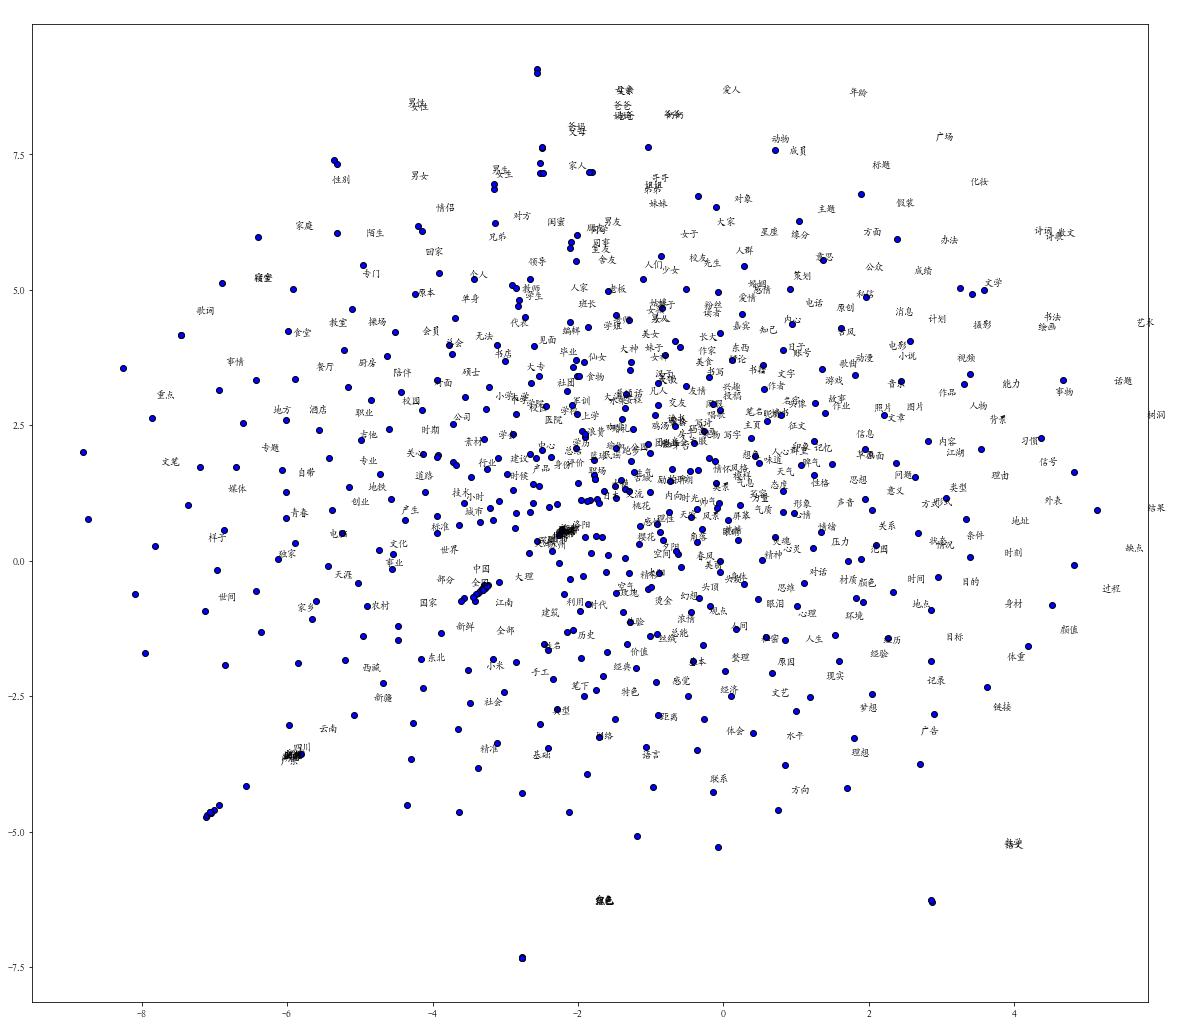

In [50]:
def plotTsne2D(word_vectors,words_list):
    tsne = TSNE(n_components=2,random_state=0,n_iter=10000,perplexity=20)
    # 在控制台输出过程中，默认小数会以科学计数法的形式输出，若不需要加上下面这句
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)
    labels = words_list
    
    plt.figure(figsize=(20,18))
    plt.scatter(T[:,0],T[:,1],c='blue',edgecolors='k')
    
    for label,x,y in zip(labels,T[:,0],T[:,1]):
        plt.annotate(label,xy=(x+1,y+1),xytext=(0,0),textcoords='offset points')

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['Kai']
plt.rcParams['axes.unicode_minus'] = False

plotTsne2D(word_vectors,words_list)

### 利用LDA算法进行主题词提取

In [52]:
# for article in corpus:
dictionary = corpora.Dictionary(corpus)
# 将 dictionary 转化为一个词袋
common_corpus = [dictionary.doc2bow(text) for text in corpus]
tfidf = models.TfidfModel(common_corpus)
corpusTfidf = tfidf[common_corpus]

lda = LdaModel(corpusTfidf, num_topics=10, id2word = dictionary, passes=20)

results = lda.print_topics(num_topics=10, num_words=3)
for res in results:
    print(res[1])

0.000*"真心话" + 0.000*"大冒险" + 0.000*"提问"
0.002*"脱单" + 0.002*"凡人" + 0.001*"嘉宾"
0.000*"兵法" + 0.000*"网文" + 0.000*"三十"
0.000*"小丸子" + 0.000*"明信片" + 0.000*"二十多岁"
0.000*"学期" + 0.000*"流逝" + 0.000*"自已"
0.000*"后会有期" + 0.000*"第三句" + 0.000*"按钮"
0.000*"自考" + 0.000*"南区" + 0.000*"宝莱坞"
0.000*"小叔叔" + 0.000*"附图" + 0.000*"小团体"
0.002*"喜欢" + 0.002*"树洞" + 0.001*"投稿"
0.001*"购买" + 0.000*"限时" + 0.000*"材质"


In [53]:
# 将LDA模型保存起来方便日后对新文章进行主题预测
lda.save('lda.model')
test = "生活是一座围城，但校园不是。校园是时光精心雕刻的礼物，里面到处有十几岁长发飘飘的女孩子，朝气执着的男孩子，有单纯追求的理想和生活，还有那些用心守候的友情爱情。秋天的梧桐树铺满教学楼的道路，在密密麻麻的习题中痴迷地偷看窗外的世界，静谧、自由；冬天的大雪来势汹汹，裹着厚棉袄走在冰封的湖边独自去上课，长大的世界只有自己可以取暖；春天，随着冰雪一起褪去的还有沉重的身心，但新的一年生活好像也没什么变化；夏天有吃不完的西瓜和冰棍，如果你可以和我一起逃课，我会告诉你后山夜晚的星星很美。提起校园，或许它并不精彩，重复到近乎单调，但我们都会无比怀念年轻的自己和那些有梦做的年纪。春天濛濛的细雨还没有离开大地，夏日离别的笙歌已在悄悄响起。又快到一年毕业季，「简书交友」专题携手「简书校园」、「简书会员」、「摄影」一起推出「恰同学少年」校园创作交友大赛。请将文章以以下形式投稿至「」专题、摄影作品可投稿至「」专题。本次活动设置了丰富的奖项和奖品，参赛内容可为小学到大学，培训学校等等你经历过的任何一个校园，校园必须为的大学，虚拟意义上的校园无法参赛，，所有简友仅需写出你曾经经历过的校园生活即可参赛。感谢对本次校园创作交友大赛的，除了提供奖金支持以外，还带来了八折的购买折扣。已是简书会员的简友参与本次比赛即可线上时长；所有参与本次比赛的简友均可获得购买简书会员的资格。详细会员权益请见：参加摄影奖的文章不参考文章质量，仅参考摄影作品，但建议对摄影作品加上一定的文字描述。片子必须原创，拒绝糊片，张数不限，可用snapseed、PS等软件修图，一旦发现盗图，永久取消参与简书活动的资格；一等奖一名：500元二等奖三名：200元三等奖五名：50元创作奖视文字部分内容而定，摄影仅做锦上添花的辅助说明。一等奖二名：1000元二等奖三名：500元三等奖五名：200元凡在本次比赛参与作品中找到同校同学，你们可以将自己的互相发布到彼此的文章，只要有五名以上的同校同学，你可以获得19元打赏。每人仅能获得一次且必须在自己的文章评论区集齐五名校友评论。收集齐后点击链接附上你的文章链接和校友评论楼层，通过验证即可获奖。登记地址：交友专题会对你提供的文章进行质量审核，单纯为了凑齐人数而没达到参赛标准的文章将被视为不符合规则。本次比赛人气最高的五篇文章和点赞人气前三的评论作者都可以获得人气奖，人气奖可与以上奖项重复获得。文章评分：0.4阅读量+0.3 评论数+0.3 点赞数，得分取前5名。人气奖奖品为：100元2018年3月27日-2018年4月20日，预计2018年5月上旬公布结果，获奖结果首发（微信号：jianshuio）。1.文章建议采用记叙性、回忆性散文、诗歌，校园生活和校园情，请勿全文叙述你的爱情（同理友情、师生情等等），不接受小说等虚构类作品；2.快速找到校友：点击列表找到自己的学校，或者点击联系负责人加入学校社群。结交校友可以100%获得。3.活动不局限于在校生参与，任何简友都可以写出你憧憬/经历过的校园生活；4.简书对所有参赛文章具有使用权，简书交友专题对活动具有最终解释权；「恰同学少年」校园创作交友大赛同步合作伙伴、引力说（微信号：GravityYLS）、清华帮（微信号：THU_bang）、小也电台（微信号：xiaoyeradio），获奖作品将同步发表在以上平台。加入简书第一步，添加简书交友官方微信群（已在前面九群的请不要重复添加）。"

test = jieba.lcut(test)

# 文档转换成bow
doc_bow = dictionary.doc2bow(test)
# 得到新文档的主题分布
doc_lda = lda[doc_bow]
type = doc_lda[1][0]
print(results[type][1])

0.000*"学期" + 0.000*"流逝" + 0.000*"自已"
